# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [1]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import dotenv

# create your own .env file and add in your directory in the format
# SKU_DATASET_DIR = r"your_directory"
# dotenv.load_dotenv()
# SKU_DATASET_DIR = os.getenv("SKU_DATASET_DIR")
sku_dataset_dir = r"C:\Users\BLOOM\Documents\Github\term7cv\dataset\SKU110K_fixed"
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.9.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [2]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [3]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## Load data

In [4]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)

## Visualise data

C:\Users\BLOOM\AppData\Local\Temp\ipykernel_5020\3197192673.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[1], row[2], row[3], row[4]


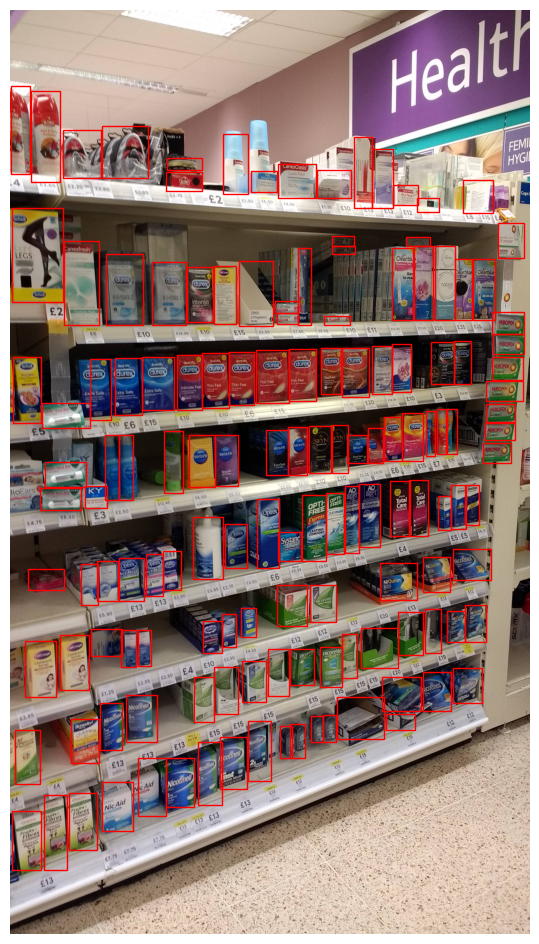

In [5]:
data_num, set = 10, 'test' 
image_num = sku_dataset_dir + rf'\images\{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv("C:/Users/BLOOM/Documents/Github/term7cv/dataset/SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Predict
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

In [6]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

img_path = "dataset/SKU110K_fixed/images/val_400.jpg"

images = [
    'dataset/SKU110K_fixed/images/val_110.jpg',
    'dataset/SKU110K_fixed/images/val_116.jpg',
    'dataset/SKU110K_fixed/images/val_166.jpg',
    'dataset/SKU110K_fixed/images/val_400.jpg',
    'dataset/SKU110K_fixed/images/val_472.jpg',
]

## Export Ground Truth Annotations

In [7]:
# import pandas as pd
# import json

# images = [
#     'val_110.jpg',
#     'val_116.jpg',
#     'val_166.jpg',
#     'val_400.jpg',
#     'val_472.jpg',
# ]

# # Read the Excel file
# annotations_df = pd.read_csv('dataset/SKU110K_fixed/annotations/annotations_val.csv')

# for image_name in images:
#     filtered_df = annotations_df.loc[annotations_df.iloc[:, 0] == image_name]

#     # Create a list of bounding box dictionaries
#     bounding_boxes = []
#     for _, row in filtered_df.iterrows():
#         bbox = {
#             "x_min": row.iloc[1],
#             "y_min": row.iloc[2],
#             "x_max": row.iloc[3],
#             "y_max": row.iloc[4],
#             # "width": row.iloc[5],
#             # "height": row.iloc[6],
#         }
#         bounding_boxes.append(bbox)

#     # Save the bounding boxes to annotations.json
#     with open(f'annotations/ground_truth/annotations_{image_name}.json', 'w') as f:
#         json.dump(bounding_boxes, f)

## Predict Functions

In [8]:
def get_image_tensors(img_size, img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    image_np = img.astype(np.uint8)
    image_np = np.expand_dims(image_np, axis=0)
    return img, image_np
    
def non_max_suppression(boxes, scores, score_threshold, nms_threshold):
    """
    Apply non-maximum suppression to remove overlapping bounding boxes.
    """
    # print(boxes, scores)
    indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold, nms_threshold)
    return indices.flatten()

def get_annotated_img_objects(img, boxes, scores, isScaled=False, score_threshold=0.15, iou_threshold=0.9, max_box_size=100):
    image = np.array(img)
    objects = 0
    bounding_boxes = []

    print("Before NMS + Score Threshold:", len(boxes))

    # Apply NMS to get the indices of the selected boxes
    selected_indices = non_max_suppression(boxes, scores, score_threshold, iou_threshold)

    print("After NMS + Score Threshold:", len(selected_indices))

    for i in selected_indices:
        box = boxes[i]
        y_min, x_min, y_max, x_max = box

        if isScaled:
            y_min, x_min, y_max, x_max = int(y_min), int(x_min), int(y_max), int(x_max)
        else:
            # Scale coordinates to image size
            y_min = int(y_min * image.shape[0])
            x_min = int(x_min * image.shape[1])
            y_max = int(y_max * image.shape[0])
            x_max = int(x_max * image.shape[1])

        # Calculate box width and height
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Check if the box exceeds the maximum allowable size
        if max_box_size is not None and (box_width > max_box_size or box_height > max_box_size):
            continue

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        objects += 1

        bbox = {
            "x_min": x_min,
            "y_min": y_min,
            "x_max": x_max,
            "y_max": y_max,
            # "width": box_width,
            # "height": box_height
        }
        bounding_boxes.append(bbox)

    return image, objects, bounding_boxes

In [22]:
def perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, isScaled=False, max_box_size=120, saveBoxes=False):
    model = hub.load(model_path)
    img, image_np = get_image_tensors(img_size, img_path)
    
    results = model(image_np)

    boxes = results['detection_boxes'][0].numpy()
    scores = results['detection_scores'][0].numpy()
    classes = results['detection_classes'][0].numpy()
    num_detections = int(results['num_detections'][0].numpy())

    print("Image shape:", image_np.shape)
    print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)

    img, objects, bounding_boxes = get_annotated_img_objects(img, boxes, scores, isScaled, score_threshold, iou_threshold, max_box_size)
    
    image_name = os.path.splitext(os.path.basename(img_path))[0]
    # save annotated image
    output_path = f"images/{model_name}_{image_name}_{score_threshold}_{iou_threshold}.jpg"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, img)

    if saveBoxes:
        print("Bounding Boxes:", len(bounding_boxes), image_name)
        with open(f'annotations/predicted/{model_name}_{image_name}.json', 'w') as f:
            json.dump(bounding_boxes, f)
        
    print("No. of objects:", objects)
    plt.imshow(img)
    plt.show()

    return scores

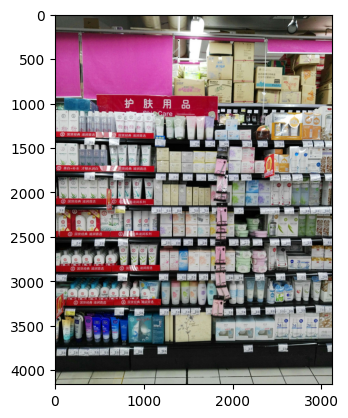

In [10]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

img_path = './dataset/SKU110K_fixed/images/val_400.jpg'
image_np = load_image_into_numpy_array(img_path)
plt.imshow(image_np)
plt.show()

In [19]:
def count_bounding_boxes(txt_file_path):
    with open(txt_file_path, 'r') as file:
        bounding_box_count = sum(1 for _ in file)
    return bounding_box_count

count = count_bounding_boxes("SKU110K_fixed/labels/val/val_400.txt")
print(count)

222


In [ ]:
import json
import numpy as np
from sklearn.metrics import average_precision_score

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def calculate_map(predicted_boxes, ground_truth_boxes, iou_threshold=0.5):
    # Calculate IoU matrix
    iou_matrix = np.zeros((len(ground_truth_boxes), len(predicted_boxes)))
    for i, gt_box in enumerate(ground_truth_boxes):
        for j, pred_box in enumerate(predicted_boxes):
            iou_matrix[i, j] = calculate_iou(pred_box, gt_box)

    # Calculate AP for each class
    num_classes = 1  # Update this value if you have multiple classes
    average_precisions = []

    for class_id in range(num_classes):
        y_true = np.zeros(len(ground_truth_boxes))
        y_scores = np.zeros(len(predicted_boxes))

        for j, pred_box in enumerate(predicted_boxes):
            iou_scores = iou_matrix[:, j]
            max_iou = np.max(iou_scores)
            max_iou_idx = np.argmax(iou_scores)

            if max_iou >= iou_threshold:
                # Matched prediction
                if y_true[max_iou_idx] == 0:
                    # True positive (not matched to any other prediction)
                    y_true[max_iou_idx] = 1
                    y_scores[j] = max_iou
                else:
                    # False positive (matched to a different prediction)
                    y_scores[j] = 0.0
            else:
                # False positive (no match above the IoU threshold)
                y_scores[j] = 0.0

        # Handle unmatched predicted boxes (false positives)
        unmatched_indices = np.where(y_scores == 0.0)[0]
        for unmatched_idx in unmatched_indices:
            y_true = np.insert(y_true, unmatched_idx, 0)
            y_scores = np.insert(y_scores, unmatched_idx, 0.0)

        # Handle unmatched ground truth boxes (false negatives)
        unmatched_indices = np.where(y_true == 0)[0]
        for unmatched_idx in unmatched_indices:
            y_true = np.insert(y_true, unmatched_idx, 1)
            y_scores = np.insert(y_scores, unmatched_idx, 0.0)

        average_precision = average_precision_score(y_true, y_scores)
        average_precisions.append(average_precision)

    # Calculate Mean Average Precision (MAP)
    map_score = np.mean(average_precisions)

    return map_score

## EfficientDet
(SSD with EfficientNet-b0 + BiFPN feature extractor, shared box predictor and focal loss), trained on COCO 2017 dataset.

Image shape: (1, 448, 448, 3)
Model Result Shapes: (1, 100, 4) (1, 100) (1, 100) tf.Tensor([100], shape=(1,), dtype=int32)
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 73
No. of objects: 73


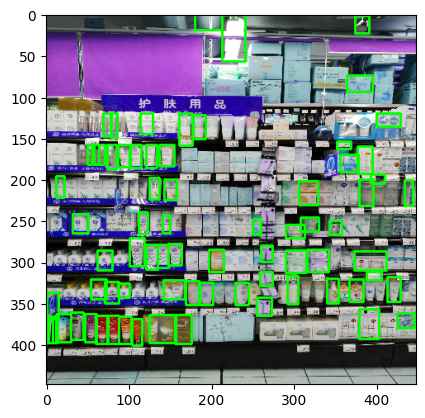

In [23]:
model_name = "EfficientDetLite4"
model_path = "https://tfhub.dev/tensorflow/efficientdet/lite4/detection/1"
img_size = (448,448)
score_threshold = 0.05
iou_threshold = 0.8

# Load model and perform predictions
model = hub.load(model_path)
img, image_np = get_image_tensors(img_size, img_path)
boxes, scores, classes, num_detections = model(image_np)

print("Image shape:", image_np.shape)
print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)

boxes = boxes[0].numpy()
scores = scores[0].numpy()

img, objects, bounding_boxes = get_annotated_img_objects(img, boxes, scores, isScaled=True, score_threshold=score_threshold, iou_threshold=iou_threshold, max_box_size=120)

image_name = os.path.splitext(os.path.basename(img_path))[0]
# save annotated image
output_path = f"images/{model_name}_{image_name}_{score_threshold}_{iou_threshold}.jpg"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_path, img)

print("No. of objects:", objects)
plt.imshow(img)
plt.show()

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 47
No. of objects: 47


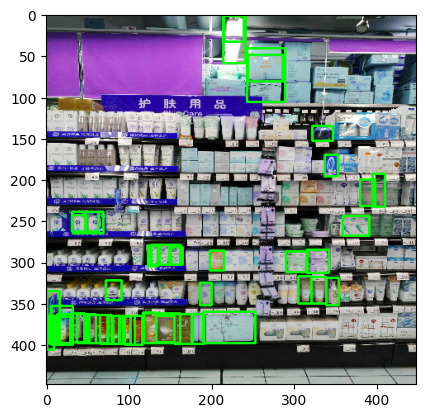

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 37
No. of objects: 37


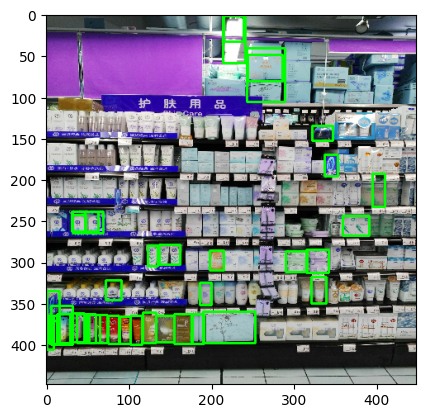

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 32
No. of objects: 32


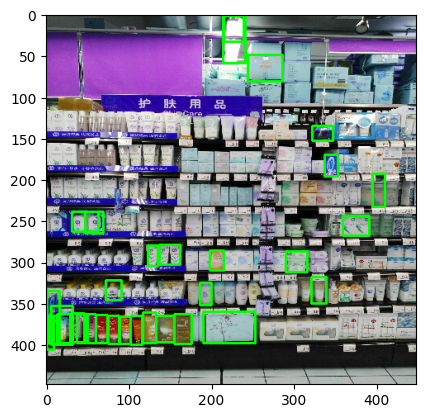

In [24]:
model_name = "EfficientDetD0"
model_path = "https://www.kaggle.com/models/tensorflow/efficientdet/frameworks/TensorFlow2/variations/d0/versions/1"
img_size = (448,448)
score_threshold = 0.07
iou_threshold = 0.8

scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.7, saveBoxes=False)

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 25
No. of objects: 25


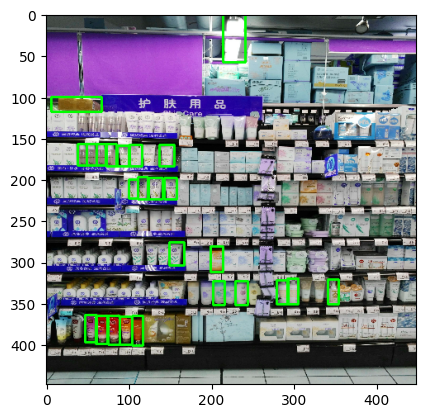

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 24
No. of objects: 24


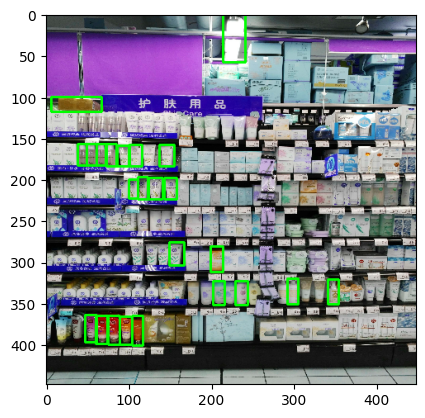

Image shape: (1, 448, 448, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 22
No. of objects: 22


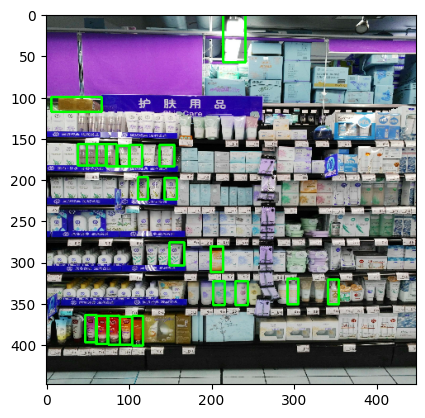

In [25]:
model_name = "EfficientDetD7"
model_path = "https://www.kaggle.com/models/tensorflow/efficientdet/frameworks/TensorFlow2/variations/d7/versions/1"
img_size = (448,448)
score_threshold = 0.07
iou_threshold = 0.8

scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.7, saveBoxes=False)

In [26]:
print(scores)

[0.1552397  0.14197591 0.14191641 0.11941593 0.10694663 0.10381824
 0.10353103 0.10299546 0.10282397 0.09821904 0.09801811 0.09411006
 0.08588175 0.08447383 0.084433   0.08437565 0.08245295 0.07963563
 0.0790555  0.07639441 0.0739623  0.07387625 0.07082747 0.07008255
 0.07003356 0.06972686 0.06898375 0.06869391 0.06837853 0.06599625
 0.06531932 0.0651542  0.06306566 0.0617354  0.06152498 0.06064275
 0.05858837 0.05773071 0.05714888 0.0570859  0.05686659 0.05654812
 0.05505823 0.05378892 0.05360235 0.05310468 0.05183507 0.05137324
 0.05087386 0.05074688 0.05020763 0.04952382 0.0491996  0.04906087
 0.04894296 0.04818554 0.04816724 0.04797806 0.04768017 0.04760603
 0.04758383 0.0473995  0.04709326 0.0469354  0.0465409  0.04603463
 0.0458877  0.0458207  0.04524205 0.04522826 0.04515852 0.04478489
 0.04465847 0.04460433 0.04395882 0.0435584  0.0435532  0.04344648
 0.04334912 0.04271675 0.0422061  0.04207963 0.04187755 0.04170089
 0.041223   0.04094323 0.04074719 0.04073909 0.04052244 0.0405

## RetinaNet
tensorflow/retinanet-resnet

Retinanet (SSD with Resnet 50 v1) Object detection model, trained on COCO 2017 dataset with training images scaled to 640x640.
https://www.kaggle.com/models/tensorflow/retinanet-resnet/frameworks/tensorFlow2/variations/152-v1-fpn-1024x1024

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 66
No. of objects: 65


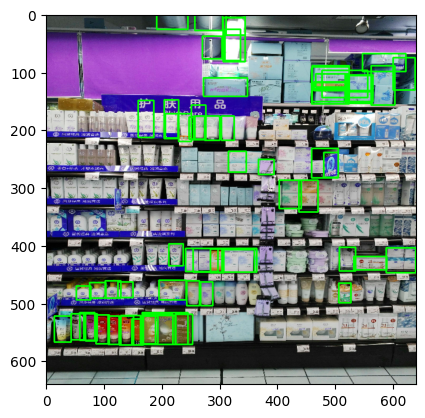

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 54
No. of objects: 53


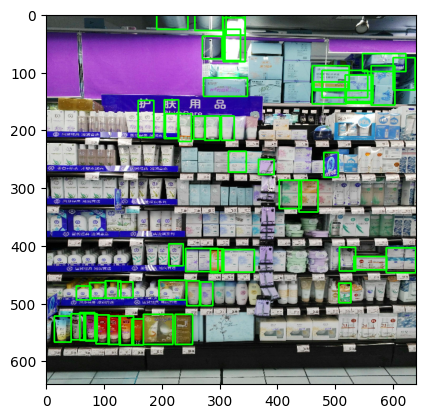

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 44
No. of objects: 43


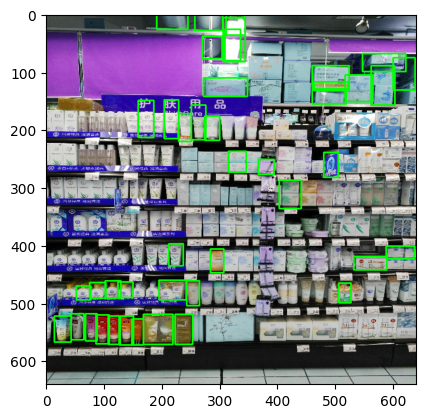

In [27]:
model_name = "RetinaNet50-v1-fpn-640x640"
model_path = "https://kaggle.com/models/tensorflow/retinanet-resnet/frameworks/TensorFlow2/variations/50-v1-fpn-640x640/versions/1"
img_size = (640,640)
score_threshold = 0.1
iou_threshold = 0.8

scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.7, saveBoxes=False)

## Faster R-CNN
tensorflow/faster-rcnn-inception-resnet-v2

Faster R-CNN with Resnet V2 Object detection model, trained on COCO 2017 dataset with trainning images scaled to 640x640.
https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/tensorFlow2/variations/640x640/versions/1

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 69
No. of objects: 63


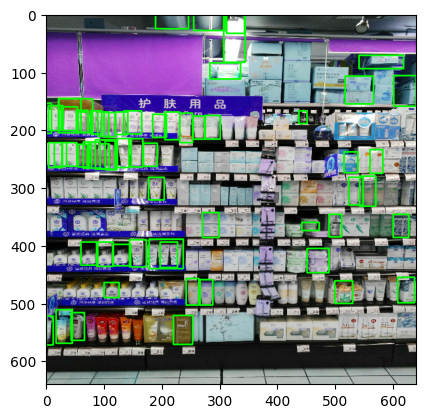

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 63
No. of objects: 58


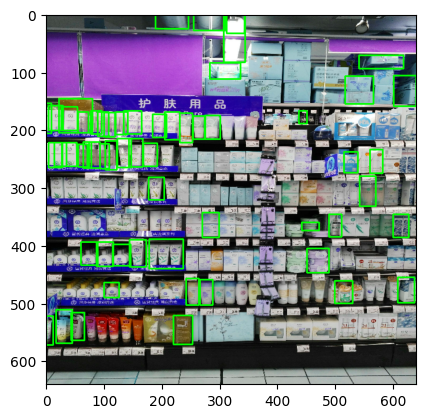

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 34
No. of objects: 30


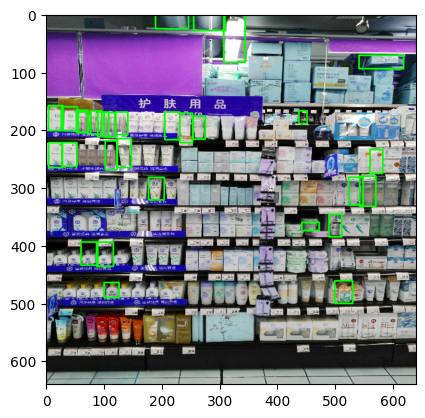

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 31
No. of objects: 28


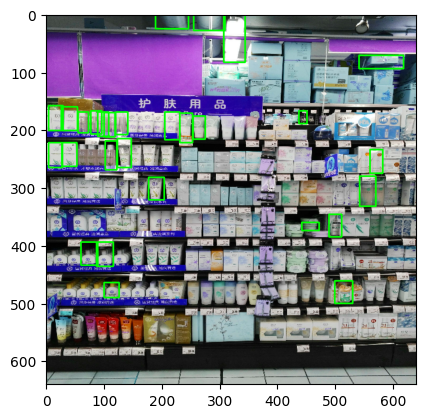

In [28]:
model_name = "Faster-RCNN-Inception-ResNet-v2"
model_path = "https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1"
img_size = (640,640)
score_threshold = 0.05
iou_threshold = 0.8

scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold=0.01, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold=0.01, iou_threshold=0.8, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, saveBoxes=False)

## MobileNet_v2
tensorflow/ssd-mobilenet-v2

Object detection model trained on the COCO dataset. 
https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/tensorFlow2/variations/fpnlite-640x640

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 79
No. of objects: 69


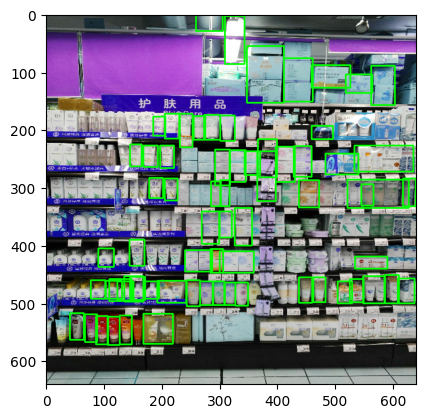

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 67
No. of objects: 58


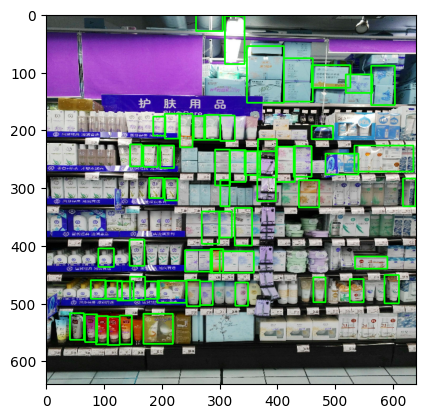

Image shape: (1, 640, 640, 3)
Model Result Shapes: (100, 4) (100,) (100,) 100
Before NMS + Score Threshold: 100
After NMS + Score Threshold: 53
No. of objects: 46


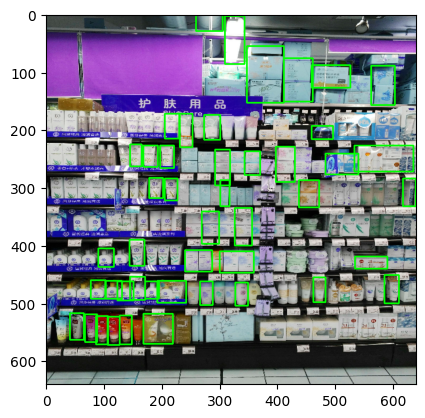

In [31]:
model_name = "SSD-MobileNet-v2"
model_path = "https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/fpnlite-640x640/versions/1"
img_size = (640,640)
score_threshold = 0.1
iou_threshold = 0.8

scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.9, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold, saveBoxes=False)
scores = perform_predictions(model_name, model_path, img_path, img_size, score_threshold, iou_threshold=0.7, saveBoxes=False)